In [ ]:
# import tensorflow as tf

# def inspect_tfrecord(file_path):
#     dataset = tf.data.TFRecordDataset(file_path)
#     for i, record in enumerate(dataset.take(1)):
#         example = tf.train.Example()
#         example.ParseFromString(record.numpy())
#         print(f"Example {i} features: {example.features.feature.keys()}")
#         for key, feature in example.features.feature.items():
#             kind = feature.WhichOneof('kind')
#             print(f"  {key}: {kind}")

# # Inspect the first file to understand its structure
# inspect_tfrecord(tfrecord_files[0])


Found 7 TFRecord files
Total samples: 5000
Label distribution:
  african: 37 samples (0.74%)
  airedale: 33 samples (0.66%)
  akita: 26 samples (0.52%)
  appenzeller: 47 samples (0.94%)
  australian kelpie: 41 samples (0.82%)
  australian shepherd: 42 samples (0.84%)
  bakharwal indian: 67 samples (1.34%)
  basenji: 18 samples (0.36%)
  beagle: 25 samples (0.50%)
  bluetick: 35 samples (0.70%)
  borzoi: 27 samples (0.54%)
  bouvier: 21 samples (0.42%)
  boxer: 27 samples (0.54%)
  brabancon: 24 samples (0.48%)
  briard: 30 samples (0.60%)
  buhund norwegian: 34 samples (0.68%)
  bulldog boston: 23 samples (0.46%)
  bulldog english: 55 samples (1.10%)
  bulldog french: 27 samples (0.54%)
  bullterrier staffordshire: 27 samples (0.54%)
  cattledog australian: 34 samples (0.68%)
  cavapoo: 44 samples (0.88%)
  chihuahua: 39 samples (0.78%)
  chippiparai indian: 42 samples (0.84%)
  chow: 27 samples (0.54%)
  clumber: 23 samples (0.46%)
  cockapoo: 37 samples (0.74%)
  collie border: 48 sa

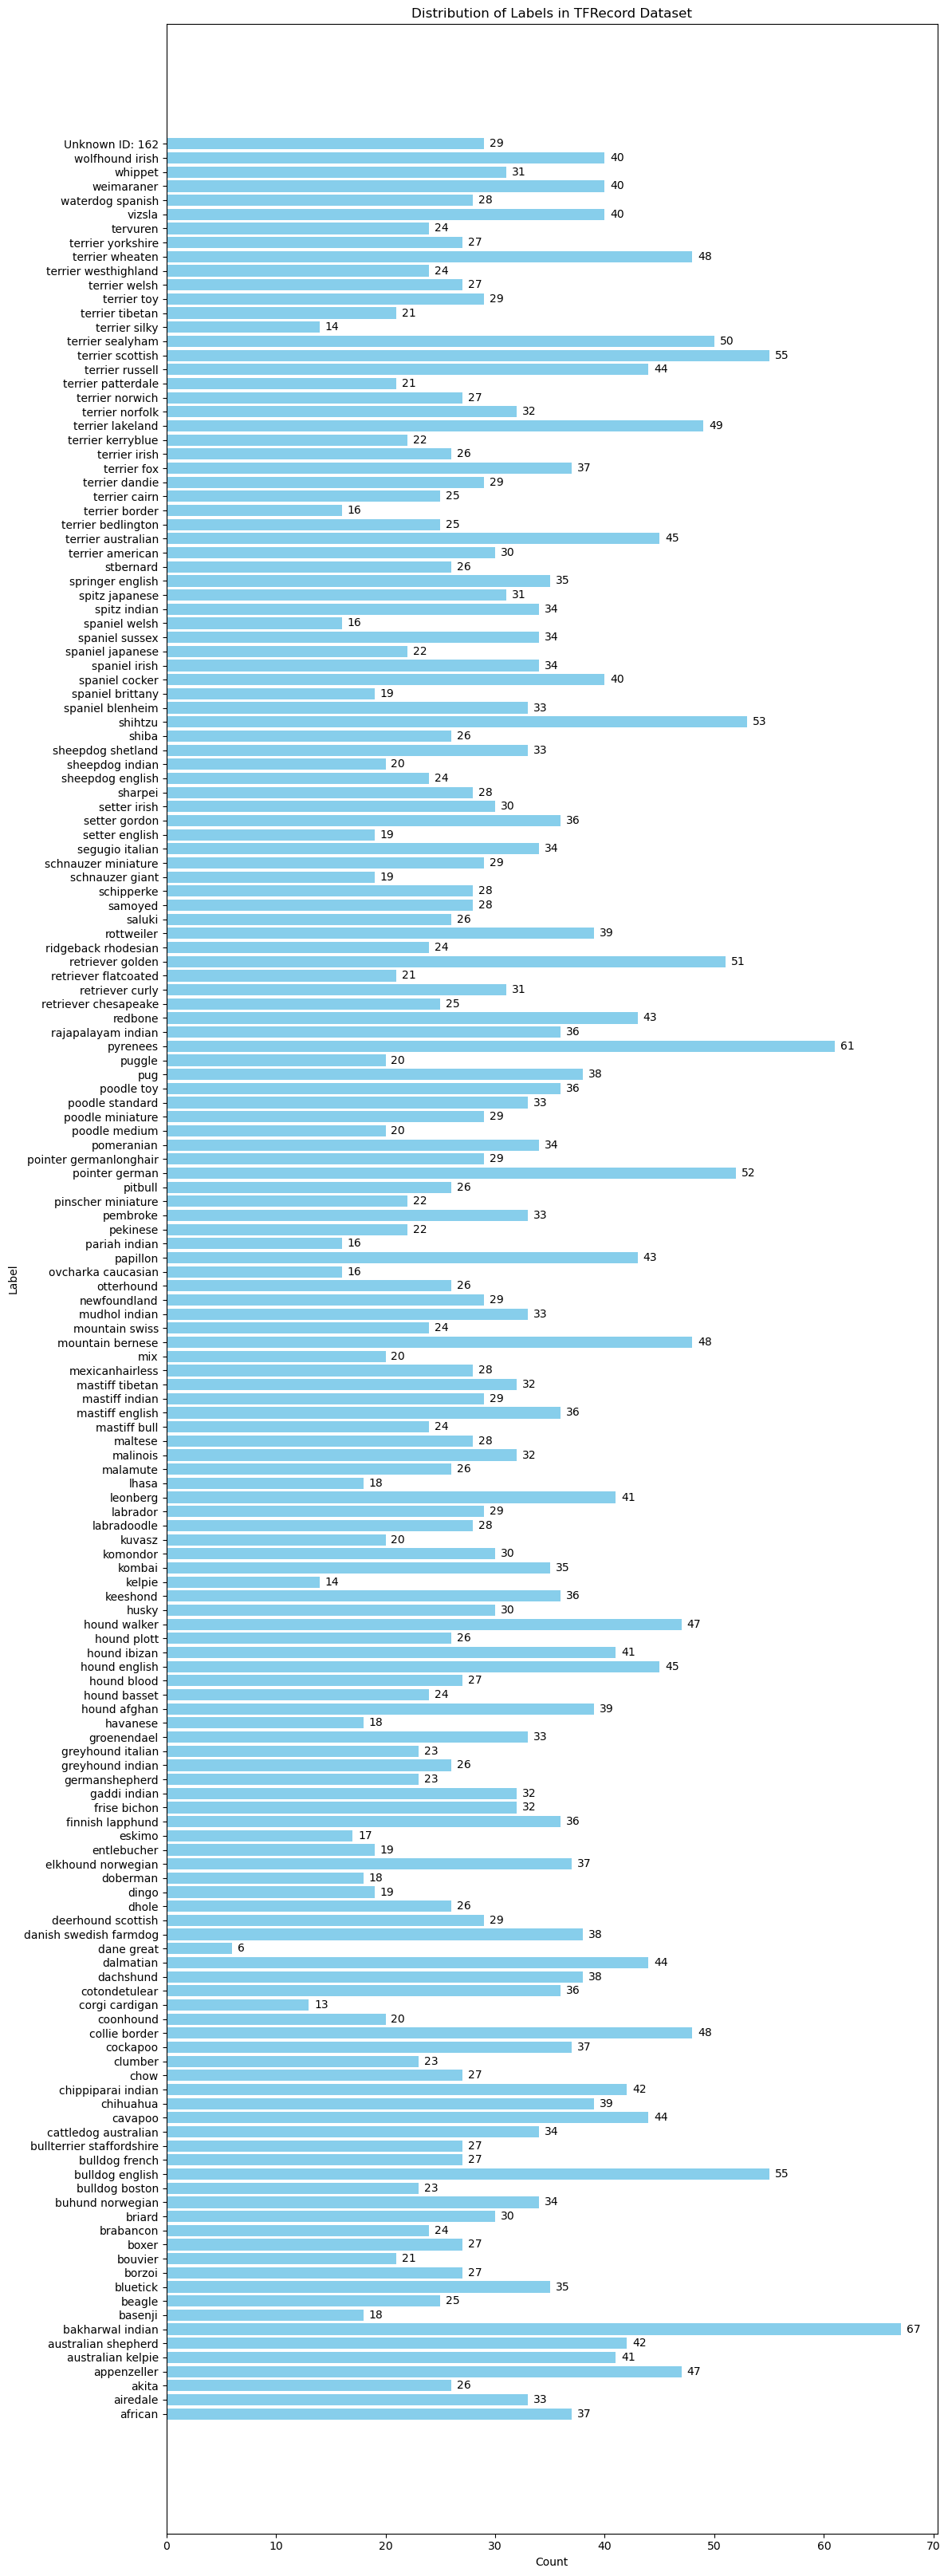

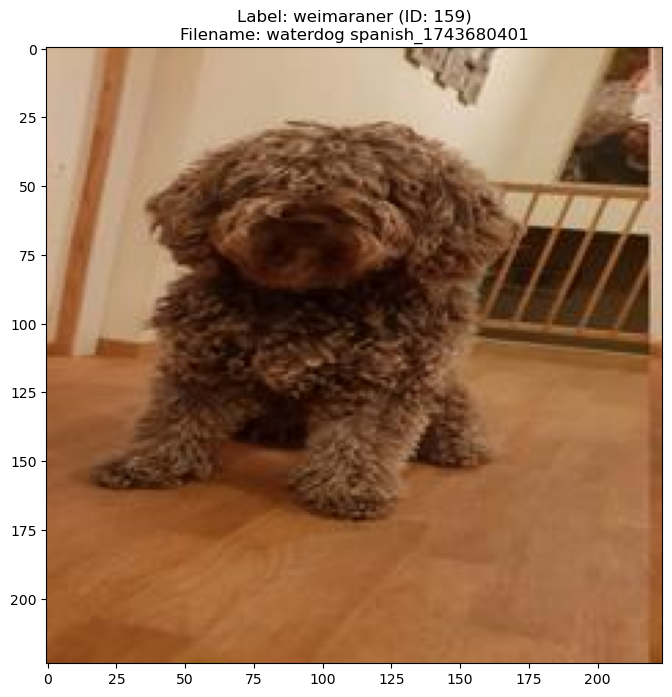

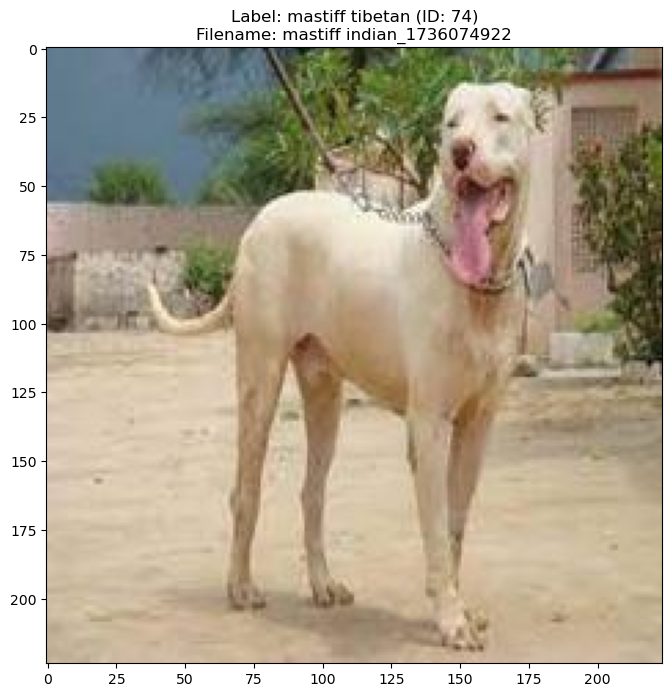

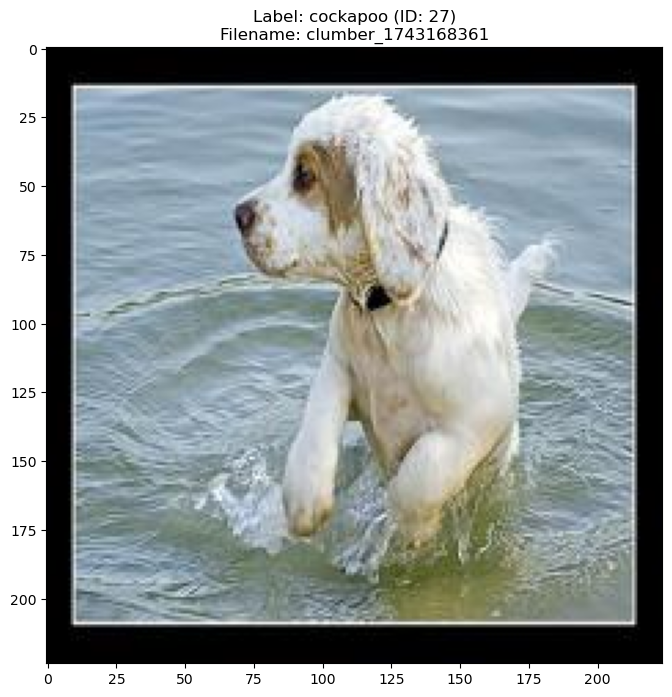

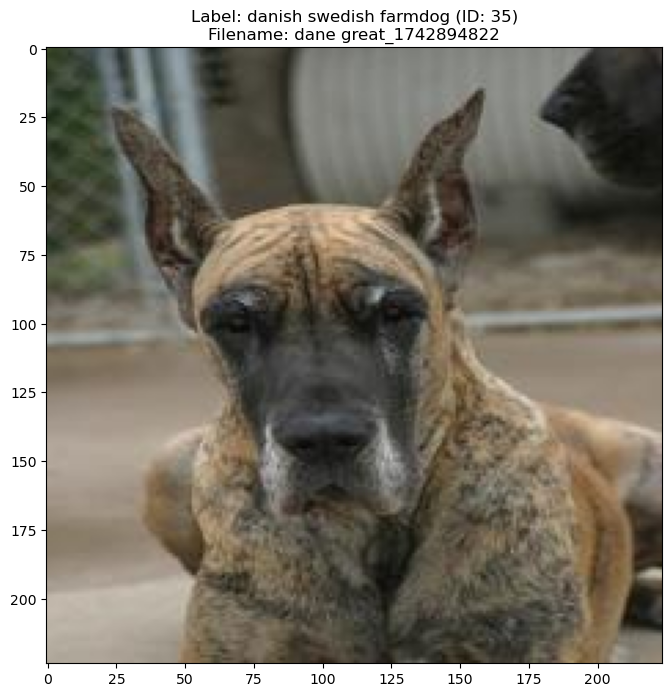

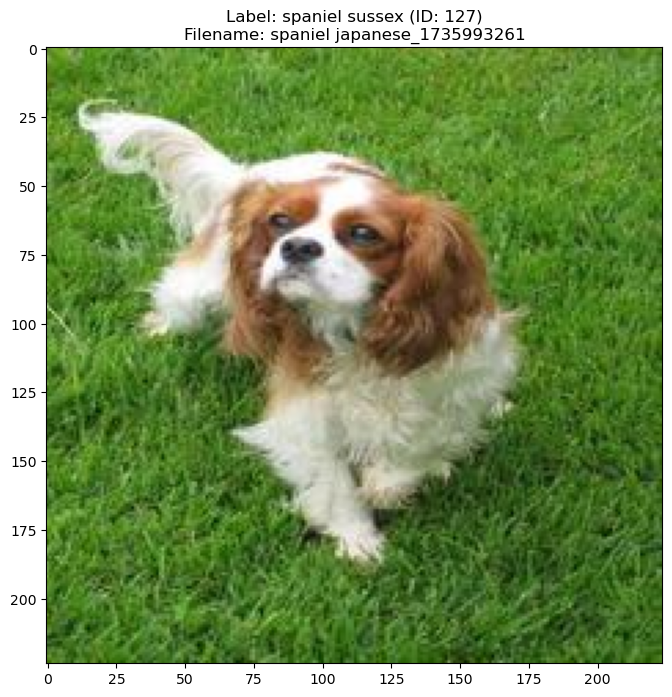

2025-04-09 16:27:23.964235: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import json
from collections import Counter

# Get list of TFRecord files
tfrecord_files = tf.io.gfile.glob('gs://creature-vision-training-set/processed/v3_2/*.tfrecord')
print(f"Found {len(tfrecord_files)} TFRecord files")

# Load the label map from GCS
with tf.io.gfile.GFile('gs://creature-vision-training-set/processed/metadata/label_map.json', 'r') as f:
    label_map = json.load(f)

# Create an inverse mapping from ID to label name
id_to_label = {v: k for k, v in label_map.items()}

def decode_example(example):
    # Define the features based on your updated pipeline code
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
        'filename': tf.io.FixedLenFeature([], tf.string)
    }
    
    # Parse the example
    parsed_features = tf.io.parse_single_example(example, feature_description)
    
    # Return both label and filename for analysis
    return parsed_features['label'], parsed_features['filename']

# Create dataset that extracts labels and filenames
dataset = tf.data.TFRecordDataset(tfrecord_files)
dataset = dataset.map(lambda x: decode_example(x))

# Collect all labels and filenames
all_labels = []
all_filenames = []
for label, filename in dataset:
    all_labels.append(int(label.numpy()))
    all_filenames.append(filename.numpy().decode('utf-8'))

# Count label occurrences
label_counts = Counter(all_labels)

# Convert counts to lists for visualization
labels = []
counts = []
for label_id, count in sorted(label_counts.items()):
    label_name = id_to_label.get(label_id, f"Unknown ID: {label_id}")
    labels.append(label_name)
    counts.append(count)

# Calculate percentages (for logging purposes)
total_samples = sum(counts)
percentages = [count / total_samples * 100 for count in counts]

# Print statistics
print(f"Total samples: {total_samples}")
print("Label distribution:")
for label, count, percentage in zip(labels, counts, percentages):
    print(f"  {label}: {count} samples ({percentage:.2f}%)")

# Analyze filename distribution
filename_counts = Counter(all_filenames)
duplicate_files = {filename: count for filename, count in filename_counts.items() if count > 1}

print("\nFilename distribution:")
print(f"  Unique filenames: {len(filename_counts)}")
print(f"  Total files: {len(all_filenames)}")
print(f"  Duplicate files: {len(duplicate_files)}")

if duplicate_files:
    print("\nDuplicate files found:")
    for filename, count in sorted(duplicate_files.items(), key=lambda x: x[1], reverse=True):
        print(f"  {filename}: {count} occurrences")

# Adjust figure height based on number of groups
plt.figure(figsize=(12, max(6, len(labels) * 0.2)))
bars = plt.barh(labels, counts, color='skyblue')
plt.xlabel('Count')
plt.ylabel('Label')
plt.title('Distribution of Labels in TFRecord Dataset')
plt.tight_layout()

# Add count labels on the bars
for bar, count in zip(bars, counts):
    plt.text(
        bar.get_width() + 0.5,
        bar.get_y() + bar.get_height() / 2,
        str(count),
        ha='left',
        va='center'
    )
plt.show()

# Function to visualize a few examples with their labels and filenames
def visualize_examples(num_examples=5):
    full_dataset = tf.data.TFRecordDataset(tfrecord_files)
    full_dataset = full_dataset.map(decode_full_example)
    
    for i, (image, label, filename) in enumerate(full_dataset.take(num_examples)):
        label_id = label.numpy()
        label_name = id_to_label.get(int(label_id), f"Unknown label ID: {label_id}")
        filename_str = filename.numpy().decode('utf-8')
        
        plt.figure(figsize=(8, 8))
        plt.imshow(image.numpy())
        plt.title(f"Label: {label_name} (ID: {label_id})\nFilename: {filename_str}")
        plt.show()

def decode_full_example(example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
        'filename': tf.io.FixedLenFeature([], tf.string)
    }
    parsed_features = tf.io.parse_single_example(example, feature_description)
    image = tf.io.parse_tensor(parsed_features['image'], out_type=tf.uint8)
    return image, parsed_features['label'], parsed_features['filename']

# Uncomment to visualize examples
visualize_examples(5)


In [ ]:

def validate_tfrecord_glob(gcs_pattern: str):
    """
    Prints the matched file paths for a given GCS glob pattern.
    
    Args:
        gcs_pattern: Glob pattern like 'gs://your-bucket/path/**/*.tfrecord'
    """
    print(f"Searching for TFRecord files with pattern:\n  {gcs_pattern}")
    matched_files = tf.io.gfile.glob(gcs_pattern)

    if not matched_files:
        print("❌ No files matched.")
    else:
        print(f"✅ Found {len(matched_files)} files:")
        for path in matched_files[:30]:  # Show first 10
            print(f"  - {path}")
        if len(matched_files) > 10:
            print("  ...")

# Example usage
validate_tfrecord_glob("gs://creature-vision-training-set/processed/**/*.tfrecord")



In [1]:
from google.cloud import storage
import pandas as pd
import json

# 🔧 Config
BUCKET_NAME = "creature-vision-training-set"
BLOB_NAME = "processed/metadata/label_map.json"
CSV_PATH = "label_map_correct.csv"  # Local path to your true label CSV

# Load the CSV
df = pd.read_csv(CSV_PATH, header=None)  # No header assumed
breeds = df[0].tolist()

# Create the label map: {"breed_name": index}
label_map = {breed.strip(): idx for idx, breed in enumerate(breeds)}

# Upload to GCS
client = storage.Client()
bucket = client.bucket(BUCKET_NAME)
blob = bucket.blob(BLOB_NAME)

# Serialize and upload
blob.upload_from_string(
    data=json.dumps(label_map, indent=2),
    content_type="application/json"
)

print(f"✅ label_map.json uploaded to gs://{BUCKET_NAME}/{BLOB_NAME}")


✅ label_map.json uploaded to gs://creature-vision-training-set/processed/metadata/label_map.json
